In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

import os
cwd=os.getcwd()
os.chdir(cwd[:len('StableRemaster')+cwd.find('StableRemaster')])

from tqdm import tqdm

In [2]:
from src import *

In [3]:
DATA_PATH = './data/02_scenes/'

In [4]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

In [5]:
segmenter = background_segmentation_loader()

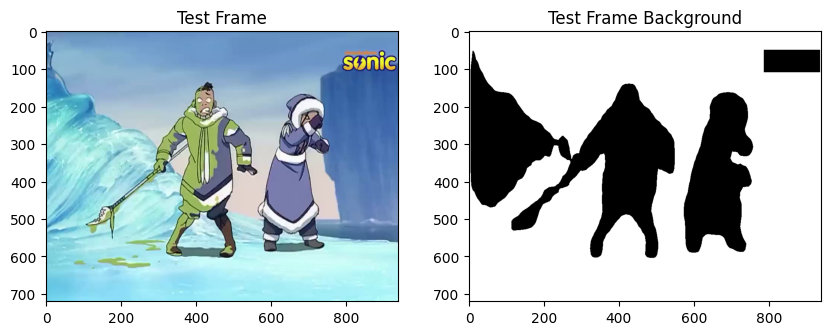

In [6]:
test_frame1 = frames[0]

bg1,bg_mask1 = segmenter(test_frame1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask1, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

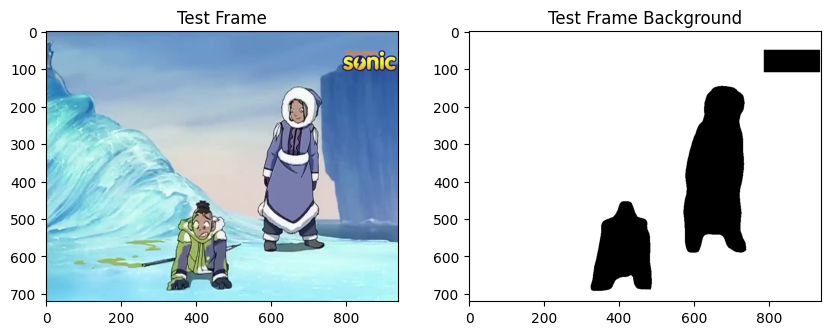

In [7]:
test_frame2 = frames[70]

bg2, bg_mask2 = segmenter(test_frame2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame2, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask2, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

In [8]:
def get_new_window_padding(frame_shape):
    new_width = frame_shape[0]*16//9
    padding = (new_width-frame_shape[1])//2
    return padding

def get_new_window_mask(frame_shape):
    new_width = frame_shape[0]*16//9
    new_window_mask = np.ones((frame_shape[0],new_width))
    left_bar = (new_width-frame_shape[1])//2
    right_bar = new_width-left_bar
    new_window_mask[:,left_bar:right_bar]=0
    return new_window_mask

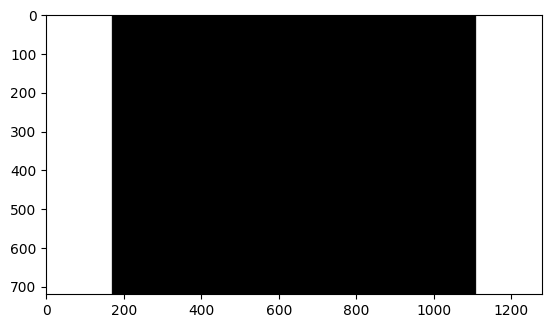

In [9]:
new_window_mask=get_new_window_mask(test_frame1.shape)
plt.imshow(new_window_mask,'gray')

In [ ]:
if torch.cuda.is_available():
    print('Device: CUDA')
    print('-'*30)
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        revision="fp16",
        torch_dtype=torch.float16,
    )
    device = torch.device('cuda')
else:
    print('Device: CPU')
    print('-'*30)
    pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting",)
    device = torch.device('cpu')

pipe = pipe.to(device)

In [24]:
m1 = get_new_window_mask(test_frame1.shape)*255
t1 = np.pad(test_frame1, ((0,0),(170,170),(0,0)),'constant',constant_values=(0,0))
t1 = Image.fromarray(t1).convert("RGB")
m1 = Image.fromarray(m1).convert("RGB")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(t1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(m1, cmap='gray')
ax2.set_title('Test Frame Mask')

# show the figure
plt.show()

In [ ]:
n1 = pipe(prompt='',image=t1, mask_image=m1,height=720,width=1280).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
plt.imshow(n1)
plt.title('Expanded Frame')